# Volcanos
This notebook makes volcano plots to show how many surfaces we found

In [1]:
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import tqdm
from pymatgen.matproj.rest import MPRester
from gaspy import utils

%matplotlib inline

In [2]:
rcParams.update({'font.sans-serif': 'Helvetica'})
rcParams.update({'font.family': 'sans-serif'})
rcParams.update({'font.size': 7})
rcParams.update({'savefig.dpi': 600})

# Initialize

## CO2RR

In [2]:
## Set the target energy
#optimum_energy = -0.6
#dE_min = -0.7
#dE_max = -0.5
#dist_xlims = (-3, 0)
#dist_ticks = np.arange(-4, 2 1)
#max_dist = max(np.abs(dE_min-optimum_energy), np.abs(dE_max-optimum_energy))
#xlabel = 'CO Adsorption Energy, $\Delta E_{CO}$ [eV]'
#ylabel = '$-|\Delta E_{CO}-0.6|$ [eV]'
#figure_save_name = 'volcano_co2rr.pdf'
#
## Load the data
#with open('../CO2RR_predictions.pkl', 'r') as f:
#    dft_results, ml_results = pickle.load(f)

## HER

In [3]:
# Set the target energy
optimum_energy = -0.27
dE_min = -0.37
dE_max = -0.17
dist_xlims = (-1.5, 0.5)
dist_ticks = np.arange(-1.5, 1, 0.5)
max_dist = max(np.abs(dE_min-optimum_energy), np.abs(dE_max-optimum_energy))
xlabel = 'H Adsorption Energy, $\Delta E_H$ [eV]'
ylabel = '-|Distance from optimal| [eV]'
figure_save_name = 'volcano_her.pdf'

# Load the data
with open('../HER_predictions.pkl', 'r') as f:
    dft_results, ml_results = pickle.load(f)

In [4]:
# Pull out the data
dft_docs = [result[0] for result in dft_results]
ml_docs = [result[0] for result in ml_results]

# Define the elements we want excluded
excluded_elements = set(['Ca', 'Na', 'Nb', 'S', 'Se'])

# Find all of the compositions of each MPID so that we can
# later parse out any sites whose bulks have elements on the exclusion list
mpids = set(doc['mpid'] for doc in dft_docs + ml_docs)
composition_by_mpid = dict.fromkeys(mpids)
mp_key = utils.read_rc('matproj_api_key')
with MPRester(mp_key) as mp_db:
    for mpid in tqdm.tqdm(mpids):
        entry = mp_db.get_entry_by_material_id({'task_ids': mpid})
        # Store the composition
        comp = entry.as_dict()['composition'].keys()
        composition_by_mpid[mpid] = set(comp)

# Filter the documents and energies for DFT
filtered_docs = []
for doc in dft_docs:
    mpid = doc['mpid']
    comp = composition_by_mpid[mpid]
    if not comp.intersection(excluded_elements):
        filtered_docs.append(doc)
dft_docs = filtered_docs
# Filter the documents and energies for ML
filtered_docs = []
for doc in ml_docs:
    mpid = doc['mpid']
    comp = composition_by_mpid[mpid]
    if not comp.intersection(excluded_elements):
        filtered_docs.append(doc)
ml_docs = filtered_docs

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-linux-x86_64.egg/pymatgen/ext/matproj.py:106: UserWarning: If you query for structure data encoded using MP's Structure Notation Language (SNL) format and you use `mp_decode=True` (the default) for MPRester queries, you should install dependencies via `pip install pymatgen[matproj.snl]`.
  warnings.warn("If you query for structure data encoded using MP's "
100%|██████████| 3404/3404 [04:56<00:00, 11.48it/s]


In [5]:
# Calculate the y-axis of the volcanos, i.e., the distance from optimal energy
dft_distances = np.array([-np.abs(doc['energy']-optimum_energy) for doc in dft_docs])
ml_distances = np.array([-np.abs(doc['energy']-optimum_energy) for doc in ml_docs])

# Jitter the distances
def jitter(array):
    ''' Thanks to yoavram on Stack Overflow for this one'''
    stdev = 0.001*(max(array)-min(array))
    return array + np.random.randn(len(array)) * stdev
dft_distances = jitter(dft_distances)
ml_distances = jitter(ml_distances)

# Plot

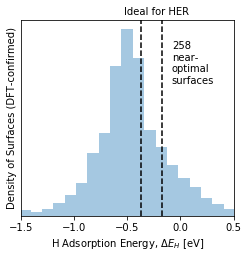

In [9]:
# Plot settings/initialization
figsize = (3.46457, 3.46457)
fontsize = 10
point_size = 6
step = 0.05
fig = plt.figure(figsize=figsize)

# Make the histogram
dft_energies = [doc['energy'] for doc in dft_docs]
ax = sns.distplot(dft_energies, kde=False)
# Format the histogram
ax.set_yticks([])
_ = ax.set_xticks(dist_ticks)
_ = ax.tick_params(labelsize=fontsize)
_ = ax.set_ylabel('Density of Surfaces (DFT-confirmed)', fontsize=fontsize)
_ = ax.set_xlabel(xlabel, fontsize=fontsize)
_ = ax.set_xlim(dist_xlims)
# Label the zooming bounds on the histogram
fig.text(0.5, 0.975, 'Ideal for HER', fontsize=fontsize)
plt.axvline(x=dE_min, linestyle='--', color='k')
plt.axvline(x=dE_max, linestyle='--', color='k')

# Annotate
n_dft_hits = len([doc for doc in dft_docs if dE_min < doc['energy'] < dE_max])
fig.text(0.69, 0.7, '%d\nnear-\noptimal\nsurfaces' % (n_dft_hits), fontsize=fontsize)

plt.tight_layout()
plt.savefig(figure_save_name, transparent=True, bbox_inches='tight')

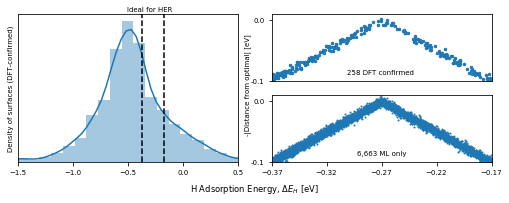

In [14]:
# Plot settings/initialization
figsize = (7.08661, 2.5)   # 7.08661 is 180 mm in inches (required by Nature)
point_size = 6
step = 0.05
nbins = 18
fig = plt.figure(figsize=figsize)

# Make the histogram
dist_ax = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
dft_energies = [doc['energy'] for doc in dft_docs]
dft_energies_Cu = [doc['energy'] for doc in dft_docs
                   if 'Cu' in composition_by_mpid[doc['mpid']]]
_ = sns.distplot(dft_energies, kde=True, ax=dist_ax, norm_hist=False)

# Format the histograms
dist_ax.set_yticks([])
_ = dist_ax.set_xticks(dist_ticks)
_ = dist_ax.set_ylabel('Density of surfaces (DFT-confirmed)')
_ = dist_ax.set_xlim(dist_xlims)
# Label the zooming bounds on the histogram
plt.axvline(x=dE_min, linestyle='--', color='k')
plt.axvline(x=dE_max, linestyle='--', color='k')
fig.text(0.25, 0.95, 'Ideal for HER')

# Make the DFT volcano
dft_ax = plt.subplot2grid((2, 2), (0, 1))
dft_ax.scatter(dft_energies, dft_distances, s=point_size)
# Format it
_ = dft_ax.set_xticks([])
dft_ax.set_xlim((dE_min, dE_max))
_ = dft_ax.set_ylim((-max_dist, 0.01))
dft_ax.set_yticks([0., -0.1])
dft_ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# Annotate
n_dft_hits = len([a for a in dft_energies if dE_min < a < dE_max])
fig.text(0.68, 0.6, '%d DFT confirmed' % (n_dft_hits))

# Make the ML volcano
ml_ax = plt.subplot2grid((2, 2), (1, 1))
ml_energies = [doc['energy'] for doc in ml_docs]
ml_energies_Cu = [doc['energy'] for doc in ml_docs
                   if 'Cu' in composition_by_mpid[doc['mpid']]]
ml_ax.scatter(ml_energies, ml_distances, s=point_size/6)
# Format it
_ = ml_ax.set_xticks(np.arange(dE_min, dE_max+step, step))
ml_ax.set_xlim((dE_min, dE_max))
_ = ml_ax.set_ylim((-max_dist, 0.01))
ml_ax.set_yticks([0., -0.1])
ml_ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# Annotate
n_ml_hits = len([a for a in ml_energies if dE_min < a < dE_max])
fig.text(0.7, 0.15, '{:,} ML only'.format(n_ml_hits))

# Label the panels
_ = fig.suptitle(xlabel, x=0.5, y=0)
_ = fig.text(0.48, 0.8, ylabel, rotation=90)
plt.tight_layout()

plt.savefig(figure_save_name[:-4] + '_SI.pdf', transparent=True, bbox_inches='tight')